# 05 Misuse vs Systemic Failure (MIT × GMF)

**Goal:** Compare “intentional misuse” vs “unintentional/system failures” using MIT intent and GMF technical failures.

This notebook:
- Builds an incident-level join between MIT and GMF (where both exist)
- Summarizes intent distributions among GMF-labeled incidents
- Explores which GMF failure types co-occur with intentional vs unintentional incidents

In [4]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

DATA = Path("../data")
OUT = Path("../outputs/figures")
OUT.mkdir(parents=True, exist_ok=True)

inc = pd.read_csv(DATA / "incidents.csv")
mit = pd.read_csv(DATA / "classifications_MIT.csv") if (DATA / "classifications_MIT.csv").exists() else None
gmf = pd.read_csv(DATA / "classifications_GMF.csv") if (DATA / "classifications_GMF.csv").exists() else None

inc.columns = [c.strip().lower() for c in inc.columns]
if mit is not None: mit.columns = [c.strip().lower() for c in mit.columns]
if gmf is not None: gmf.columns = [c.strip().lower() for c in gmf.columns]

def normalize_incident_id(df):
    if df is None:
        return None
    if "incident id" in df.columns and "incident_id" not in df.columns:
        df = df.rename(columns={"incident id": "incident_id"})
    return df

mit = normalize_incident_id(mit)
gmf = normalize_incident_id(gmf)

print("Incidents:", inc.shape)
print("MIT:", None if mit is None else mit.shape)
print("GMF:", None if gmf is None else gmf.shape)

Incidents: (1367, 9)
MIT: (1242, 8)
GMF: (326, 21)


In [5]:
def pick_col_by_keywords(df, must_have_keywords, nice_to_have=None):
    nice_to_have = nice_to_have or []
    candidates = []
    for c in df.columns:
        cl = c.lower()
        if all(k in cl for k in must_have_keywords):
            score = sum(1 for k in nice_to_have if k in cl)
            non_null = df[c].notna().sum()
            candidates.append((score, non_null, c))
    if not candidates:
        return None
    return sorted(candidates, reverse=True)[0][2]

intent_col = "intent" if (mit is not None and "intent" in mit.columns) else None
domain_col = "risk_domain" if (mit is not None and "risk_domain" in mit.columns) else None

failure_col = pick_col_by_keywords(gmf, ["failure"], nice_to_have=["technical", "known", "ai"]) if gmf is not None else None

print("MIT intent column:", intent_col)
print("MIT domain column:", domain_col)
print("GMF failure column:", failure_col)

MIT intent column: intent
MIT domain column: None
GMF failure column: known ai technical failure snippets


In [6]:
if mit is None or gmf is None or "incident_id" not in mit.columns or "incident_id" not in gmf.columns:
    print("Missing MIT/GMF or incident_id; cannot join.")
else:
    mit_inc = mit[["incident_id"] + ([intent_col] if intent_col else []) + ([domain_col] if domain_col else [])].drop_duplicates()
    gmf_inc = gmf[["incident_id"] + ([failure_col] if failure_col else [])].drop_duplicates()

    joined = mit_inc.merge(gmf_inc, on="incident_id", how="inner")
    print("Joined MIT×GMF incidents:", joined.shape)
    display(joined.head())

Joined MIT×GMF incidents: (326, 3)


,incident_id,intent,known ai technical failure snippets
0,1,Unintentional,Snippet Text: \nPart of YouTube’s plan is to i...
1,2,Unintentional,Snippet Text: \n
2,3,Unintentional,Snippet Text: The plane had been repainted and...
3,4,Unintentional,Snippet Text: Tempe police said the self-drivi...
4,5,Unintentional,Snippet Text: Some of the reported cases sound...


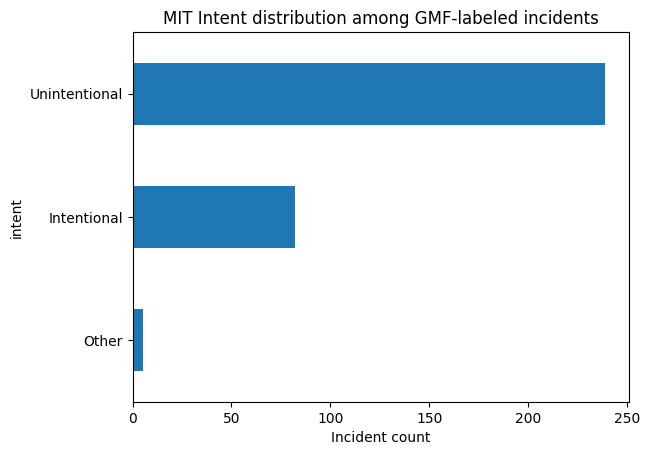

Intent % among GMF-labeled incidents:


intent
Unintentional    73.3
Intentional      25.2
Other             1.5
Name: count, dtype: float64

In [7]:
def savefig(fig, name):
    fig.savefig(OUT / name, bbox_inches="tight", dpi=200)

if "joined" in globals() and intent_col:
    vc = joined[intent_col].dropna().astype(str).value_counts()
    fig = plt.figure()
    ax = fig.add_subplot(111)
    vc.sort_values().plot(kind="barh", ax=ax)
    ax.set_title("MIT Intent distribution among GMF-labeled incidents")
    ax.set_xlabel("Incident count")
    savefig(fig, "70_intent_among_gmf.png")
    plt.show()

    pct = (vc / vc.sum() * 100).round(1)
    print("Intent % among GMF-labeled incidents:")
    display(pct)

In [8]:
if "joined" in globals() and intent_col and failure_col:
    df = joined.dropna(subset=[intent_col, failure_col]).copy()
    df[intent_col] = df[intent_col].astype(str)
    df[failure_col] = df[failure_col].astype(str)

    top_fail = df[failure_col].value_counts().head(12).index
    df = df[df[failure_col].isin(top_fail)]

    ct = pd.crosstab(df[intent_col], df[failure_col], normalize="index")
    ct_pct = (ct * 100).round(1)
    print("Failure type mix by intent (% within intent):")
    display(ct_pct)

    ct_pct.to_csv(OUT / "71_failure_by_intent_pct.csv")

Failure type mix by intent (% within intent):


known ai technical failure snippets,Snippet Text: \n,"Snippet Text: \nPart of YouTube’s plan is to increase human moderation and tweak its algorithm, “training machine-learning technology across other challenging content areas, including child safety and hate speech.” YouTube will also cut down on channels that receive monetization and advertisements attached to these videos. Since YouTube Kids also includes ads — many of which, Golin says, aren’t child appropriate — this will affect channels and videos on the platform.\nRelated Classifications: Tuning Issues\n, Snippet Text: ""Recommendations are designed to optimize watch time, there is no reason that it shows content that is actually good for kids. \nRelated Classifications: Tuning Issues\n, Snippet Text: On YouTube today, children are being exploited for money. YouTubers with channels specifically marketed toward children are cranking out videos to provide kids with loads of content to consume, as each video around 16 minutes long. (Which is the sweet spot for maximum ad revenue.) Frankly, YouTubers are practically begging their viewers to “smash” that like button and comment on their videos.\nI spent a weekend babysitting my brother’s children and they spent most of that time watching channels like Chad Wild Clay. He would ask a question like, “Who is going to win this game?” ask kids to comment their predictions in the comments and then proceed to play the game, giving the kids the answer in the same video. He’d do that same thing several times throughout the video.\n\nWhat’s the point of the interactive bits if they can just skip ahead and get their answers without commenting at all? It’s simple: the more engagement the video gets, the more likely it is to be picked up by YouTube’s recommendation algorithm, thus bringing in more traffic and more money.\nRelated Classifications: Tuning Issues\nSnippet Discussion: Recommendation training / video ranking is utilizing likes and engagement too much.\n, Snippet Text: Conspiracy videos also appear when children search for popular conspiracy theories. Searches for ""chemtrails,"" ""flat earth,"" and ""nibiru"" are all allowed in the app. However, it's (hopefully) unlikely that children are regularly watching these videos unless they appear as suggestions on more popular content in the app.\n\nThe conspiracy videos didn't just appear in searches or suggested videos, either. After watching several conspiracy videos, the top recommended video on the home page of YouTube Kids was a conspiracy theory about aliens on the moon:\nRelated Classifications: Tuning Issues\n, Snippet Text: The first line of defense for YouTube Kids are algorithmic filters. After that, there is a team of humans that review videos which have been flagged. If a video with recognizable children’s characters gets flagged in YouTube’s main app, which is much larger than the Kids app, it will be sent to the policy review team. YouTube says it has thousands of people working around the clock in different time zones to review flagged content. If the review finds the video is in violation of the new policy, it will be age restrictied, automatically blocking it from showing up in the Kids app. YouTube says it typically takes at least a few days for content to make its way from YouTube proper to YouTube Kids, and the hope is that within that window, users will flag anything potentially disturbing to children. YouTube also has a team of volunteer moderators, which it calls Contributors, looking for inappropriate content. YouTube says it will start training its review team on the new policy and it should be live within a few weeks. \nIt normally takes five days for supposedly child-friendly content like cartoons to get from YouTube to YouTube Kids. Within that window it is hoped users and a specially-trained team will flag disturbing content.\n\n\n\nRelated Classifications: Lack of Adversarial Robustness, Adversarial Data\n","Snippet Text: Geometrically, gender bias is f

## Notes & Limitations

- This analysis is restricted to incidents that have **both** MIT and GMF labels.
- “Intentional” vs “Unintentional” comes from the MIT taxonomy.
- Co-occurrence patterns do not imply causality; they highlight where technical failures and misuse appear together.